## Baseline without Object Detector

In [1]:
import torch

device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

### Blip

In [ ]:
# LAVIS
!pip install salesforce-lavis

import lavis
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import locale

# from typing import Sequence, Union
locale.getpreferredencoding = lambda: 'UTF-8'

# Instantiate the blip model
blip_im_text_match, image_preprocess_im_text_match, text_preprocess_im_text_match = lavis.models.load_model_and_preprocess(
    name="blip_image_text_matching", model_type="large", is_eval=True, device=device
  )

### SAM

In [ ]:
#SAM
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

from segment_anything import sam_model_registry, SamPredictor

sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
# device = "cpu"

# Instantiate SAM model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)


### Dataset

In [ ]:
# CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import clip

#Instantiate Clip
modelCLIP, preprocessCLIP = clip.load("ViT-B/16", device=device)
# modelCLIP.cuda().eval()
modelCLIP.eval()

In [ ]:
# REFCOCOG
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz

In [6]:
from torch.utils.data import Dataset, DataLoader
import json
import cv2
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[2].item(), train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [7]:
# Instantiation of Dataset and Dataloader

REFCOCOG_PATH = "refcocog"

train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocessCLIP, tokenization=clip.tokenize)
val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocessCLIP, tokenization=clip.tokenize)
test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocessCLIP, tokenization=clip.tokenize)

train_dataloader = DataLoader(train_dataset, shuffle=False)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

### Functions

In [133]:
def cosine_similarity(images_z: torch.Tensor, texts_z: torch.Tensor):
    """ Compute cosine similarity between image and text  """
    # normalization and computation
    images_z /= images_z.norm(dim=-1, keepdim=True)
    texts_z /= texts_z.norm(dim=-1, keepdim=True)
    similarity = (texts_z @ images_z.T)

    return similarity.cpu()

def center_da_gradcam(gradcam, image: Image, text_tokens: torch.Tensor = None, for_visualization=False):
    """ Compute heatmap given an image and a text query and retrieve from it a central point """
    image_norm = np.float32(image) / 255
    center = [0, 0]
    gradcam = getAttMap(image_norm, gradcam[0][1], blur=True)
    colour_map = gradcam - image_norm

    xs = []
    ys = []

    if for_visualization:
      h, w, c = colour_map.shape
      red_channel = np.zeros((h, w, 1))
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            red_channel[i][j][0] = 1
            xs.append(i)
            ys.append(j)
      if len(xs)!=0:
        center[0] = int((max(xs)+min(xs))/2)
        center[1] = int((max(ys)+min(ys))/2)
      return center, colour_map, red_channel

    else:
      for i in range(colour_map.shape[0]):
        for j in range(colour_map.shape[1]):
          if (colour_map[i][j][0] > 0.2 and colour_map[i][j][1] < 0.2 and colour_map[i][j][2] < 0.2):
            xs.append(i)
            ys.append(j)
      if len(xs)!=0:
        center[0] = int((max(xs)+min(xs))/2)
        center[1] = int((max(ys)+min(ys))/2)
      return center

# Functions for computing Accuracy
def computeIntersection(bbox, BBOX):
    """ Compute the intersection of two bounding boxes  """
    x_min = bbox[0]
    y_min = bbox[1]
    x_max = bbox[2]
    y_max = bbox[3]
    X_MIN = BBOX[0]
    Y_MIN = BBOX[1]
    X_MAX = BBOX[2]
    Y_MAX = BBOX[3]

    dx = min(x_max, X_MAX) - max(x_min, X_MIN)
    dy = min(y_max, Y_MAX) - max(y_min, Y_MIN)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area

def computeAccuracy(bbox, BBOX):
    """ Compute the intersection of union of two bounding box """
    intersection = computeIntersection(bbox, BBOX)
    area1 = (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
    area2 = (BBOX[2]-BBOX[0])*(BBOX[3]-BBOX[1])
    union = area1 + area2 - intersection
    return intersection / union

# Functions for visualization

def print_bbox(image, t_bbox, f_bbox, title):
    """ Plot image with target bbox and image with the found bbox """
    image_target_bbox = image.copy()
    for i in range(t_bbox[0], t_bbox[2]):
      for j in range(t_bbox[1], t_bbox[3]):
        if (t_bbox[0]<=i and i<=t_bbox[0]+10) or (t_bbox[1]<=j and j<=t_bbox[1]+10) or (t_bbox[2]-10<=i and i<=t_bbox[2]) or (t_bbox[3]-10<=j and j<=t_bbox[3]):
          image_target_bbox.putpixel((j, i), (225, 0, 0))

    image_found_bbox = image.copy()
    for i in range(f_bbox[0], f_bbox[2]):
      for j in range(f_bbox[1], f_bbox[3]):
        if (f_bbox[0]<=i and i<=f_bbox[0]+10) or (f_bbox[1]<=j and j<=f_bbox[1]+10) or (f_bbox[2]-10<=i and i<=f_bbox[2]) or (f_bbox[3]-10<=j and j<=f_bbox[3]):
          image_found_bbox.putpixel((j, i), (225, 0, 0))

    plt.figure(figsize=(15,8))
    # target bbox
    plt.subplot(1,2,1)
    plt.imshow(image_target_bbox)
    plt.title(title)
    plt.axis('off')
    # found bbox
    plt.subplot(1,2,2)
    plt.imshow(image_found_bbox)
    plt.title('Found Bounding Box')
    plt.axis('off')

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

### Baseline and Visualization function

In [154]:
def check_baseline(loader, dataset, visualize_colormaps = False, n_sample_to_check = 1):
  """ Visualize what the system does with a specific sample"""

  n_samples = 0

  for data_features, data_bbox in loader:

    if n_samples in range(0, n_sample_to_check-1):
      n_samples += 1
      continue

    # Problems with this specific samples
    if (n_samples in range(520,530)) or (n_samples in range(750, 770)) or (n_samples in range(2750, 2760)) or (n_samples in range(2945, 2950)):
      n_samples += 1
      continue

    # Get text queries and target bounding
    sentences = dataset.getSentences(data_features)
    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    # Get image and pass it to SAM predictor
    image = dataset.getImage(data_features)
    img = np.array(image)
    predictor.set_image(img)

    points = []
    color_maps = []
    red_channels = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point, color_map, red_channel = center_da_gradcam(gradcam, image, text_tokens=text_tokens, for_visualization=True)
      color_maps.append(color_map)
      red_channels.append(red_channel)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


    xs = []
    ys = []
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    found_bbox = [min(xs), min(ys), max(xs), max(ys)]

    # Show image and target bbox
    print_bbox(image, target_bbox, found_bbox, sentences[0])

    # Plot SAM masks
    plt.figure(figsize=(15,8))
    for i, (mask, score) in enumerate(zip(masks, scores)):
      if i <= 2:
        plt.subplot(1,3,i+1)
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(input_point, input_label, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')

    # Plot Heat Map
    if visualize_colormaps:
      num_heatmaps = min(len(sentences), 3)
      plt.figure(figsize=(15,8))
      for i in range(num_heatmaps):
        plt.subplot(1,3,i+1)
        plt.imshow(color_maps[i])
        plt.title(sentences[i])
        plt.axis('off')

      plt.figure(figsize=(15,8))
      for i in range(num_heatmaps):
        plt.subplot(1,3,i+1)
        plt.imshow(red_channels[i])
        plt.axis('off')

    # Compute Accuracy
    accuracy = computeAccuracy(found_bbox, target_bbox)
    correct = False
    if accuracy >= 0.5:
      correct = True

    print('------------------------------------------------------------------------------')
    print('Correctly Classified:', correct, '\tAccuracy:', round(accuracy, 2))
    print('------------------------------------------------------------------------------')

    break

  return

In [165]:
def baseline(loader, dataset):
  """ Baseline without Object Detector"""

  n_samples = 1
  tot_accuracy = 0
  tot_correct = 0
  s = 0

  for data_features, data_bbox in loader:

    # Problems with this specific samples
    if (n_samples in range(520,530)) or (n_samples in range(750, 770)) or (n_samples in range(2750, 2760)) or (n_samples in range(2945, 2950)):
      n_samples += 1
      s += 1
      continue

    # Get text queries and target bounding
    sentences = dataset.getSentences(data_features)
    target_bbox = [0, 0, 0, 0]
    target_bbox[0] = int(data_bbox[1].item())
    target_bbox[1] = int(data_bbox[0].item())
    target_bbox[2] = int(data_bbox[1].item() + data_bbox[3].item())
    target_bbox[3] = int(data_bbox[2].item() + data_bbox[0].item())

    # Get image and pass it to SAM predictor
    image = dataset.getImage(data_features)
    img = np.array(image)
    predictor.set_image(img)

    points = []
    for target in sentences:
      input_text = text_preprocess_im_text_match["eval"](target)
      input_image = image_preprocess_im_text_match["eval"](image).unsqueeze(0).cuda()
      text_tokens = blip_im_text_match.tokenizer(input_text, return_tensors="pt").to('cuda')
      gradcam, _ = compute_gradcam(
          blip_im_text_match, input_image, input_text, text_tokens, block_num=7
        )
      point = center_da_gradcam(gradcam, image, text_tokens=text_tokens)
      point = [point[1], point[0]]
      points.append(point)

    input_point = np.array(points)
    input_label = np.ones(len(sentences))

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

    xs = []
    ys = []
    for i in range(masks.shape[1]):
      for j in range(masks.shape[2]):
        if masks[0][i][j]*1+masks[1][i][j]*1+masks[2][i][j]*1>0:
          xs.append(i)
          ys.append(j)

    found_bbox = [min(xs), min(ys), max(xs), max(ys)]

    # Compute Accuracy
    accuracy = computeAccuracy(found_bbox, target_bbox)
    tot_accuracy += accuracy
    if accuracy>=0.5:
      tot_correct += 1

    if n_samples%100==0:
      print('TOT_Correctly Classified:', tot_correct, '/', (n_samples-s), '\tTOT_Accuracy:', round(tot_accuracy/(n_samples-s),2))
      print('-----------------------------------------------------------------')

    n_samples += 1

  return tot_correct/n_samples


### Try with some sample

------------------------------------------------------------------------------
Correctly Classified: True 	Accuracy: 0.92
------------------------------------------------------------------------------


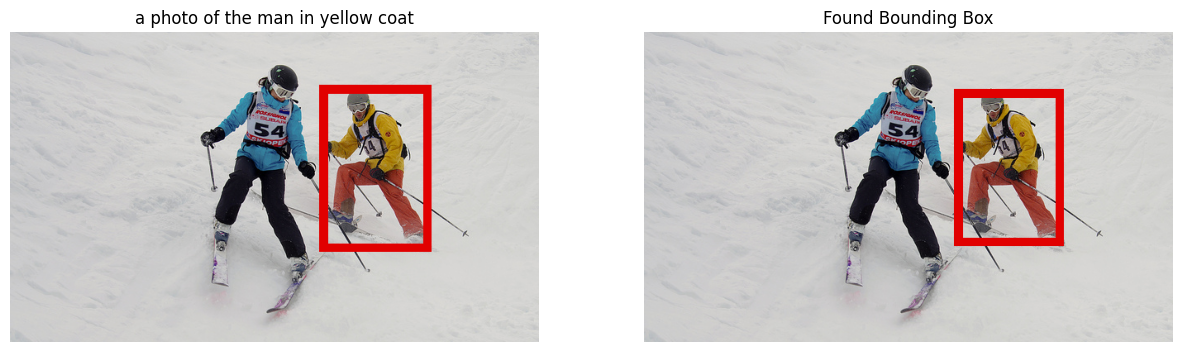

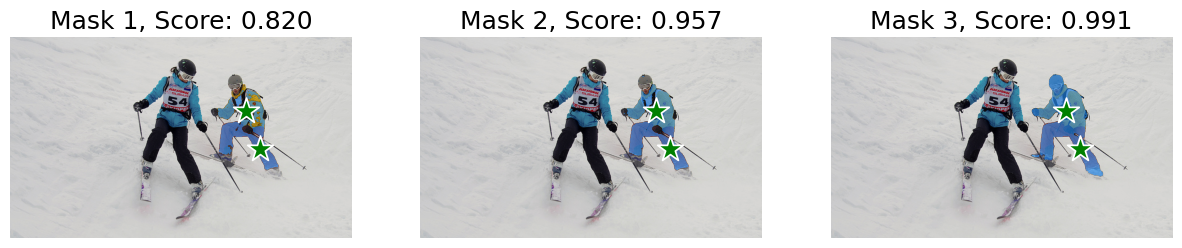

In [166]:
check_baseline(test_dataloader, test_dataset, visualize_colormaps=False, n_sample_to_check=1)

### Verify the Accuracy

In [ ]:
baseline(test_dataloader, test_dataset)